## Can you Detect Emotions based on an Image?

The following is based on the Notebook from fast.ai's course Practical Deep Learning for Coders Part 1 Lesson 1.<br>
I created my own Image Classifier to gain experience and a deeper understanding of the matter.
In this lesson, I built a simple (but effective) image classifier by fine-tuning a pretrained model. The exercise highlights how modern deep learning libraries make it straightforward to adapt state-of-the-art models to new tasks with minimal code.<br>
I decided to build on the example in the course and make a classifier that is not just a binary Classifier but can distinguish between the emotions happy, sad, and angry.

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -U fastai ddgs primp fasttransform --no-deps # modification from the original course Notbeook to deal with dependency issuses (made by User F R Khan)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.8 MB/s eta 0:00:00
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.19
    Uninstalling fastai-2.7.19:
      Successfully uninstalled fastai-2.7.19


The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "happy photos","sad photos", and "angry photos" 
1. save them in a way that their parent folder is a label of their emotion
1. Fine-tune a pretrained neural network to recognise these three groups
1. Try running this model on a picture of an angry person and see if it works.

## Step 1: Download images

In [2]:
from ddgs import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

Let's start by searching for an angry photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('angry photos', max_images=1)
urls[0]

'https://s-i.huffpost.com/gen/1224269/images/o-ANGRY-STOCK-PHOTOS-facebook.jpg'

...and then download a URL and take a look at it:

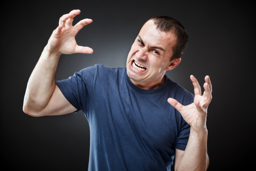

In [4]:
from fastdownload import download_url
dest = 'angry.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Looks like an angry photo to me. Lets continue by saving sad, happy and angry photos to our file system in a path of their respective categories:

In [5]:
from fastdownload import download_url
from fastai.vision.all import *
import time

searches = 'sad','happy', 'angry'
path = Path('sad_happy_or_angry')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)
    failed = verify_images(get_image_files(dest)) #checking for invalid pictures...
    failed.map(Path.unlink) # ...and removing them

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.war

## Step 2: Train our model

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it to make sure or dataset is intact:

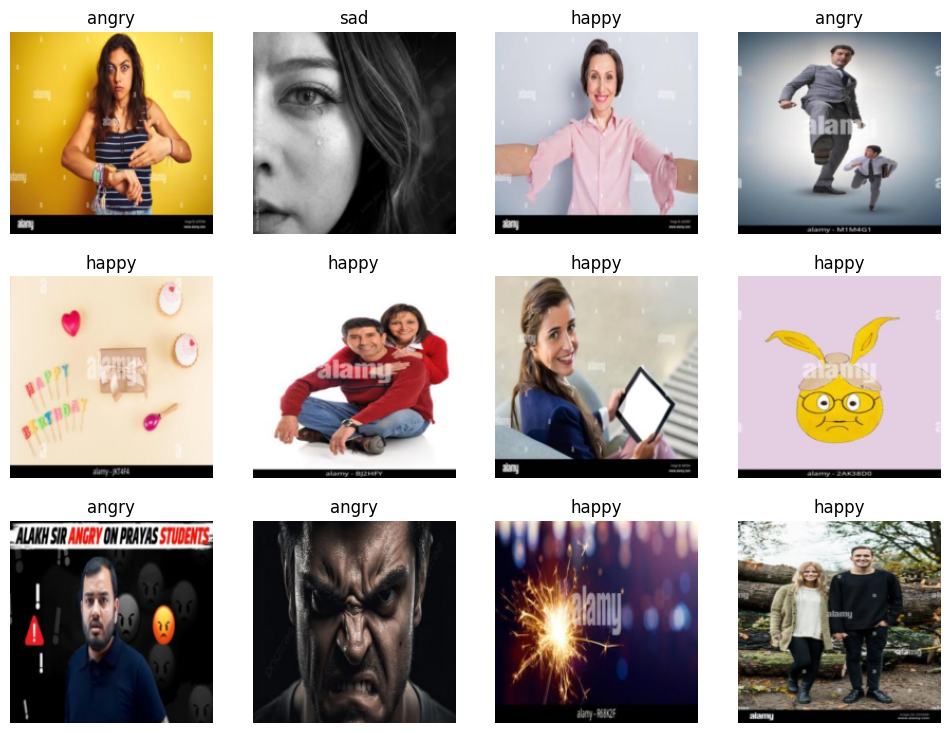

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [7]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.873288,1.075581,0.428571,00:01


epoch,train_loss,valid_loss,error_rate,time
0,1.093532,0.913910,0.326531,00:01
1,0.755283,0.995530,0.285714,00:00
2,0.553141,1.157351,0.306122,00:00
3,0.427249,1.222968,0.346939,00:00
4,0.342286,1.209974,0.326531,00:00


## Step 3: Use our model

Let's see what our model thinks about the angry picture we downloaded at the start:

In [8]:
is_angry,_,probs = learn.predict(PILImage.create('angry.jpg'))
print(f"Emotion: {is_angry}.")
print(f"Probability it's an angry photo: {probs[0]:.4f}")

Emotion: angry.
Probability it's an angry photo: 0.9742


We can see the realtive simplicity with which an image classifier can be made today. Though there are caveats to this:
1. The Algorithm might not respond to the Emotion on a persons Face (if thaths our goal) but the colorscheme (Sad: dark,blue; Angry:black, red; Happy:bright, colorful)
2. The underlying (pretrained) model was likely also trained on the images in our training and validation set, which makes dealing with original images as Inputs unreliable because the model may be overfitting to the dataset
3. has limited practical application: most of the images are stock images specifically crafted to evoke the impression of that emotion. It will likely struggle with more nuanced and noisy data

none the less these issues can be overcome with more advanced data augmentation and ML techniques. I am excited for the next lessons!
